# Finetune the X3D

* Original Author: FAIR PyTorchVideo*

> I start with X3D network pretrained on the Kinetics 400 dataset and finetune it on the UCF-CRIME dataset for video anomaly detection.


#### install dependencies

```
!pip install 'git+https://github.com/facebookresearch/fvcore'

!apt-get update
!apt-get install -y ffmpeg libsm6 libxext6

!pip install av or conda install av -c conda-forge -y
!pip install opencv-python pandas
```


#### Imports

Load the model:

In [1]:
import torch
# Choose the `x3d_s` model to load
model_name = 'x3d_m'
model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)

Using cache found in /home/etri/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [2]:
model

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv2plus1d(
        (conv_t): Conv3d(3, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        (conv_xy): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
      )
      (norm): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(54, 54, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=54, bias=False)
            (nor

#### Original Classes for UCF-CRIME (Abnormal 13 + Normal 1)

In [3]:
print(model.blocks[5]==model.blocks[-1])
model.blocks[-1]

True


ResNetBasicHead(
  (pool): ProjectedPool(
    (pre_conv): Conv3d(192, 432, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (pre_norm): BatchNorm3d(432, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pre_act): ReLU()
    (pool): AvgPool3d(kernel_size=(np.int64(16), 7, 7), stride=1, padding=0)
    (post_conv): Conv3d(432, 2048, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (post_act): ReLU()
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Linear(in_features=2048, out_features=400, bias=True)
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)

In [4]:
num_classes = 14 # UCF-CRIME 클래스 개수

in_features = model.blocks[5].proj.in_features # 기존 레이어의 입력 피처 크기 추출

# model.blocks[5].proj = torch.nn.Linear(model.blocks[5].proj.in_features, num_classes)
model.blocks[5].proj = torch.nn.Linear(in_features, num_classes) # Final Linear 레이어만 교체 (*가장 쉬운 가중치 보존 방법)

In [5]:
in_features

2048

> $y = W x + b$

- $x \in \mathbb{R}^{2048}$ : 풀링을 가친 특징 벡터 (여기선 2048 차원)

- $W \in \mathbb{R}^{N \times 2048}$ : 학습시켜야할 새 가중치 행렬

Import remaining functions:

In [6]:
import json
import urllib

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np
import random

# 기본 시드 고정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/home/etri/miniconda3/envs/py12/lib/python3.12/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/etri/miniconda3/envs/py12/lib/python3.12/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


#### Setup

Set the model to eval mode and move to desired device.

In [7]:
torch.cuda.is_available()

True

In [8]:
# Set to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected Device is {device}\n")
model = model.eval()
model = model.to(device)

Selected Device is cuda



#### Define input transform

In [9]:
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
frames_per_second = 30
model_transform_params  = {
    "x3d_xs": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 4,
        "sampling_rate": 12,
    },
    "x3d_s": {
        "side_size": 182,
        "crop_size": 182,
        "num_frames": 13,
        "sampling_rate": 6,
    },
    "x3d_m": {
        "side_size": 256,
        "train_crop_size": 224,
        "test_crop_size": 256,
        "num_frames": 16,
        "sampling_rate": 5,
    },
    "x3d_l": {
        "side_size": 356,
        "train_crop_size": 312,
        "test_crop_size": 356,
        "num_frames": 16,
        "sampling_rate": 5,
    }
}

# Get transform parameters based on model
transform_params = model_transform_params[model_name]

#### Kinetic Dataset Label(.json) and a sample video

Download the id to label mapping for the Kinetics 400 dataset on which the torch hub models were trained. This will be used to get the category label names from the predicted class ids.

In [10]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [11]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [12]:
kinetics_id_to_classname

{290: 'sharpening knives',
 115: 'eating ice cream',
 81: 'cutting nails',
 53: 'changing wheel',
 19: 'bench pressing',
 88: 'deadlifting',
 111: 'eating carrots',
 192: 'marching',
 358: 'throwing discus',
 231: 'playing flute',
 72: 'cooking on campfire',
 33: 'breading or breadcrumbing',
 218: 'playing badminton',
 276: 'ripping paper',
 244: 'playing saxophone',
 197: 'milking cow',
 169: 'juggling balls',
 130: 'flying kite',
 43: 'capoeira',
 187: 'making jewelry',
 100: 'drinking',
 228: 'playing cymbals',
 61: 'cleaning gutters',
 161: 'hurling (sport)',
 239: 'playing organ',
 361: 'tossing coin',
 395: 'wrestling',
 103: 'driving car',
 150: 'headbutting',
 147: 'gymnastics tumbling',
 186: 'making bed',
 0: 'abseiling',
 155: 'holding snake',
 278: 'rock climbing',
 71: 'cooking egg',
 182: 'long jump',
 17: 'bee keeping',
 365: 'trimming or shaving beard',
 63: 'cleaning shoes',
 86: 'dancing gangnam style',
 50: 'catching or throwing softball',
 164: 'ice skating',
 168: 

#### **UCF-Crime Data Formatting**

In [13]:
# Simply inspect the dataset
import cv2
import os

# wsl 경로에 유의
vid_sample_path = r"/mnt/c/KJM/abnormal_behavior/DB/UCF_Crimes/Videos/train/Arson/Arson002_x264.mp4"
trimmed_sample_path = r"/mnt/c/KJM/abnormal_behavior/DB/UCF_Crimes/Action_Regnition_splits(classifiction)/test_001_trimmed_3fps_16sec/Abuse/Abuse001_x264_trimmed.mp4"

vid_sample_path = trimmed_sample_path
cap = cv2.VideoCapture(vid_sample_path)
if not os.path.exists(vid_sample_path):
    print("경로에 파일이 없습니다. 경로를 다시 확인하세요.")
else: 
    print(f"Resolution of trimmed videos is {cap.get(cv2.CAP_PROP_FRAME_WIDTH)} x {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}")
    print(f"FPS of trimmed videos is {cap.get(cv2.CAP_PROP_FPS)}")

Resolution of trimmed videos is 320.0 x 240.0
FPS of trimmed videos is 3.0


In [14]:

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)
from pytorchvideo.data.encoded_video import EncodedVideo # ptv의 EncodedVideo 클래스를 활용하면 비디오 전체를 읽지 않고도 특정 시간대 효율적으로 로드 가능 


In [15]:
# 비디오 전처리: X3D 모델 입력 전, 데이터를 일정한 규격으로 맞추기 위한 전처리
transform =  ApplyTransformToKey( # pytorchvideo.transforms.ApplyTransformToKey
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(transform_params["num_frames"]),  # 균등한 간격으로 추출할 프레임 개수
            Lambda(lambda x: x/255.0), # 0~255 범위의 픽셀값을 0~1로 정규화
            NormalizeVideo(mean, std), # Kinetics로 사전학습한 픽셀 값 평균과 표준편차로 채널 정규화
            ShortSideScale(size=transform_params["side_size"]), # 가로/세로 중 짧은 변 기준 크롭
            CenterCropVideo(                                    # 앞서 크롭된 프레임 중앙에서 정방향 크롭
                crop_size=(transform_params["train_crop_size"], transform_params["train_crop_size"])
            )
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (transform_params["num_frames"] * transform_params["sampling_rate"])/frames_per_second

print(f"Calculated clip duration is {clip_duration}")

Calculated clip duration is 2.6666666666666665


In [37]:
import collections

In [41]:
def time_to_seconds(time_str):
    """
    '0:00:06' 또는 '00:06' 형태의 문자열을 초(float) 단위로 변환.
    """
    if pd.isna(time_str) or time_str == "":
        return 0.0
        
    # 숫자와 콜론(:)만 추출 (뒤에 붙는 문자열 무시)
    time_match = re.search(r"(\d+:?\d*:?\d*)", str(time_str))
    if not time_match:
        return 0.0
    
    clean_time_str = time_match.group(1)
    parts = str(clean_time_str).split(':')
    # HH:MM:SS 형식
    if len(parts) == 3:
        return float(parts[0]) * 3600 + float(parts[1]) * 60 + float(parts[2])
    # MM:SS 형식
    elif len(parts) == 2:
        return float(parts[0]) * 60 + float(parts[1])
    # 이미 숫자 형태인 경우
    try:
        return float(time_str)
    except ValueError:
        return 0.0

class UCFCrimeDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transform=None):
        """
        root_dir: 'train/' 폴더 경로
        annotation_dir: 'train/00_timestamp/' 폴더 경로
        """
        self.root_dir = root_dir
        self.transform = transform
        self.clip_metadata = []
        self.filtered_videos = []

        # CSV 파일들을 읽어 (파일 경로, 시작 시간, 종료 시간, 클래스 인덱스) 리스트 생성
        classes = sorted([d for d in os.listdir(root_dir) 
                        if os.path.isdir(os.path.join(root_dir, d)) and d != '00_timestamp'])
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

        for cls in classes:
            csv_path = os.path.join(annotation_dir, f"{cls}_timestamps.csv")
            if not os.path.exists(csv_path):
                print(f"\nCSV file not found: {csv_path}")
                continue
            
            try: 
                df = pd.read_csv(csv_path, on_bad_lines='skip', engine='c') # 오타등으로 CSV 파일에서 잘못된 줄이 있다면 건너뛰고 읽음
            except Exception as e:
                print(f"Warning: Could not read {csv_path}. Error: {e}")
                continue
            
            for _, row in df.iterrows():                
                raw_file_name = str(row['file_name']).strip().split()[0]
                video_path = os.path.join(root_dir, cls, raw_file_name)

                # 파일이 실제로 존재하는지 확인 후 메타데이터에 추가
                if os.path.exists(video_path):
                    # 'exclude'가 행 어디든 포함되어 있다면 학습에서 제외
                    # if 'exclude' in " ".join(row.astype(str)).lower():
                    #     continue

                    self.clip_metadata.append({
                        'video_path': video_path,
                        'start_time': time_to_seconds(row['start_time']),
                        'end_time': time_to_seconds(row['end_time']),
                        'label': self.class_to_idx[cls]
                    })

                else:
                    print(f"Video not found: {video_path}") 

        print(f"\nDataset initialized with {len(self.clip_metadata)} valid clips.")
        self.print_statistics()

    def __len__(self):
        return len(self.clip_metadata)

    def __getitem__(self, idx):
        item = self.clip_metadata[idx]
        video = EncodedVideo.from_path(item['video_path'])

        start = item['start_time']
        end = item['end_time']

        # # 메모리 폭주 방지를 위해 너무 긴 클립은 잘라냄
        max_dur = 4.0
        if end - start > max_dur: # 이벤트 구간 중간에서 앞뒤로 추출
            start = max(0, start - 2)
            end = min(video.duration, end + 2)

        # 지정된 start~end 구간의 비디오 데이터 로드
        # 사고 구간이 너무 짧으면 모델 입력(2초 가량)에 맞춰 여백을 두거나 조절.
        video_data = video.get_clip(start_sec=start, end_sec=end)
        
        video_tensor = video_data['video'] # (C, T, H, W)
        
        if self.transform:
            # PyTorchVideo transform은 딕셔너리 형태 입력으로
            video_data = self.transform(video_data)
            
        return video_data['video'], item['label']

    def print_statistics(self):
        counts = collections.Counter([item['label'] for item in self.clip_metadata])
        total = 0
        for idx in range(len(self.idx_to_class)):
            cls_name = self.idx_to_class[idx]
            count = counts[idx]
            total += count
            print(f"[Class] {cls_name:<20}: {count:4} clips")

        print(f"Total clips: {total}")

In [42]:
# 데이터셋 및 로더 선언
train_dataset = UCFCrimeDataset(
    root_dir="/mnt/c/JJS/UCF_Crimes/Videos/train", 
    annotation_dir="/mnt/c/JJS/UCF_Crimes/Videos/train/00_timestamp",
    transform=transform # 앞서 정의한 비디오 입력 전처리 transform
)

# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=8, 
#     shuffle=True, 
#     num_workers=1,
#     persistent_workers=True # 워커 재사용으로 메모리 안정화
# )

Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault001_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault016_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault022_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault027_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault027_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault027_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Assault/Assault042_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Burglary/Burglary029_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Burglary/Burglary063_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Burglary/Burglary064_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Burglary/Burglary064_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/train/Burglary/Burglary066_x264_2.mp4
Video 

In [18]:
# 학습 함수 정의
def train_one_epoch(model, data_loader, criterion, optimizer, device):
  model.train()
  total_loss = 0.0

  pbar = tqdm(data_loader, desc="Training", leave=True) # leave: 에폭 종료 후 진행바 남길지 여부
  # for inputs, labels in data_loader:
  for i,(inputs, labels) in enumerate(pbar):
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    pbar.set_postfix({"loss": f"{loss.item():.4f}", "avg_loss": f"{total_loss / (i + 1):.4f}"})
  return total_loss / len(data_loader)

#### **Start Training**

##### 손실함수 및 옵티마이저

- 차등 학습률 (Differential Learning Rate)

  > UCF-CRIME 다중 클래스 분류를 위한 Cross Entropy Loss 사용 <br>이때 교체한 출력헤드에 대해서만 10배 가량 큰 학습률 설정 <br>(완전 램덤 상태에서 출발하기 때문, 학술적으로 권장되는 전이 학습 전략)

##### 사전학습 가중치 동결

- **Phase 1:** Backbone(blocks[0:5])을 동결하고 새로 만든 Head만 2~3 Epoch 정도 학습. <br>(무작위 가중치가 사전 학습된 Backbone을 망치는 것을 방지)
- **Phase 2:** 모든 레이어 동결을 해제하고 전체 네트워크를 파인튠.

In [ ]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")
model.to(device)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True,
    # persistent_workers=True # 워커 재사용으로 메모리 안정화
)

# phase 1
print("\n[Phase 1] Training Head Only...")

for param in model.blocks[:5].parameters():
  param.requires_grad = False
for param in model.blocks[5].parameters():
    param.requires_grad = True

# optimizer_p1 = optim.SGD(model.blocks[5].parameters(), lr=1e-3, momentum=0.9)
optimizer_p1 = optim.AdamW(model.blocks[5].parameters(), lr=1e-3)
for epoch in range(2):
  train_loss = train_one_epoch(model, train_loader, criterion, optimizer_p1, device)
  print(f"Phase 1 - Epoch ({epoch+1}/2) : Loss {train_loss:.4f}")

# phase 2
print("\n[Phase 2] Full Fine-tuning...")
for param in model.parameters(): # 전체 레이어 trainable
    param.requires_grad = True

# Head와 backbone의 학습률을 서로 다르게 적용하기 위해 분리
# optimizer_p2 = optim.SGD([
#     {'params': model.blocks[:5].parameters(), 'lr':1e-5},
#     {'params': model.blocks[5].proj.parameters(), 'lr':1e-3} # 빠른 수렴 유발
# ], momentum=0.9, weight_decay=1e-4)
optimizer_p2 = optim.AdamW([
    {'params': model.blocks[:5].parameters(), 'lr':1e-5},
    {'params': model.blocks[5].proj.parameters(), 'lr':1e-3} # 빠른 수렴 유발
], weight_decay=1e-4)

for epoch in range(3):
  loss = train_one_epoch(model, train_loader, criterion, optimizer_p2, device)
  print(f"Phase 2 - Epoch ({epoch+1}/5) : Loss {loss:.4f}")

Selected device: cuda

[Phase 1] Training Head Only...


Training: 100%|██████████| 113/113 [11:06<00:00,  5.90s/it, loss=2.1982, avg_loss=2.2830]


Phase 1 - Epoch (1/2) : Loss 2.2830


Training: 100%|██████████| 113/113 [10:57<00:00,  5.82s/it, loss=1.8821, avg_loss=1.8581]


Phase 1 - Epoch (2/2) : Loss 1.8581

[Phase 2] Full Fine-tuning...


Training: 100%|██████████| 113/113 [11:22<00:00,  6.04s/it, loss=1.4434, avg_loss=1.6888]


Phase 2 - Epoch (1/5) : Loss 1.6888


Training: 100%|██████████| 113/113 [10:50<00:00,  5.76s/it, loss=1.2765, avg_loss=1.5760]


Phase 2 - Epoch (2/5) : Loss 1.5760


Training: 100%|██████████| 113/113 [10:55<00:00,  5.80s/it, loss=2.2236, avg_loss=1.4766]

Phase 2 - Epoch (3/5) : Loss 1.4766


In [20]:
train_dataset.class_to_idx

{'Abuse': 0,
 'Arrest': 1,
 'Arson': 2,
 'Assault': 3,
 'Burglary': 4,
 'Explosion': 5,
 'Fighting': 6,
 'Normal': 7,
 'RoadAccidents': 8,
 'Robbery': 9,
 'Shooting': 10,
 'Shoplifting': 11,
 'Stealing': 12,
 'Vandalism': 13}

In [21]:
!pwd

/mnt/c/Users/USER/Desktop/jjs/SlowFast/projects/x3d


In [22]:
# torch.save(model, "x3d_ucfcrime_mulclass_2+3ep.pt")
# # <class 'torch.nn.modules.module.Module'>

torch.save(model.state_dict(),"x3d_ucfcrime_mulclass_2+3ep_SGD_26011512.pth")
# <class 'collections.OrderedDict'>

#### **Evaluation & Inference on a few samples**

In [23]:
# 내가 학습시킨 가중치 
# from model import create_x3d

# X3D = create_x3d()
# x3d_model = torch.load("./x3d_ucfcrime_mulclass_2+5ep.pt")
# type(x3d_model)


In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
import numpy as np

# 테스트용 데이터셋 및 로더  
test_dataset = UCFCrimeDataset(
    root_dir="/mnt/c/JJS/UCF_Crimes/Videos/test", 
    annotation_dir="/mnt/c/JJS/UCF_Crimes/Videos/test/00_timestamp",
    transform=transform 
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=0 # 테스트 시에는 shuffle=False로 설정하여 순서 유지
)

Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson007_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson010_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson016_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson022_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson007_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson009_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson010_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson010_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson011_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson016_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson018_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson022_x264_2.mp4
Video not found: /mnt/c/JJS/UCF_Crimes/Videos/test/Arson/Arson035_x264_2.mp4

In [25]:
type(model)

pytorchvideo.models.net.Net

In [26]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    print("Starting Evaluation...")
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            
            # 모델 추론
            outputs = model(inputs)
            
            # 확률값 계산 (AUC용)
            probs = F.softmax(outputs, dim=1)
            
            # 예측값 추출 (Accuracy용)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 리스트를 numpy 배열로 변환
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Accuracy 계산
    acc = accuracy_score(all_labels, all_preds)

    # AUC 계산 (Multi-class One-vs-Rest 방식)
    # 데이터셋에 모든 클래스가 포함되어 있는지 확인 후 계산
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError as e:
        print(f"AUC calculation error (possibly missing classes in test set): {e}")
        auc = 0.0

    return all_labels, all_preds, all_probs, acc, auc

# 평가 실행
all_labels, all_preds, all_probs, test_acc, test_auc = evaluate_model(model, test_loader, device)

print(f"\n[Test Result]")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test AUC Score: {test_auc:.4f}")

Starting Evaluation...


Evaluating: 100%|██████████| 37/37 [02:38<00:00,  4.29s/it]


[Test Result]
Final Test Accuracy: 0.2414
Final Test AUC Score: 0.7843


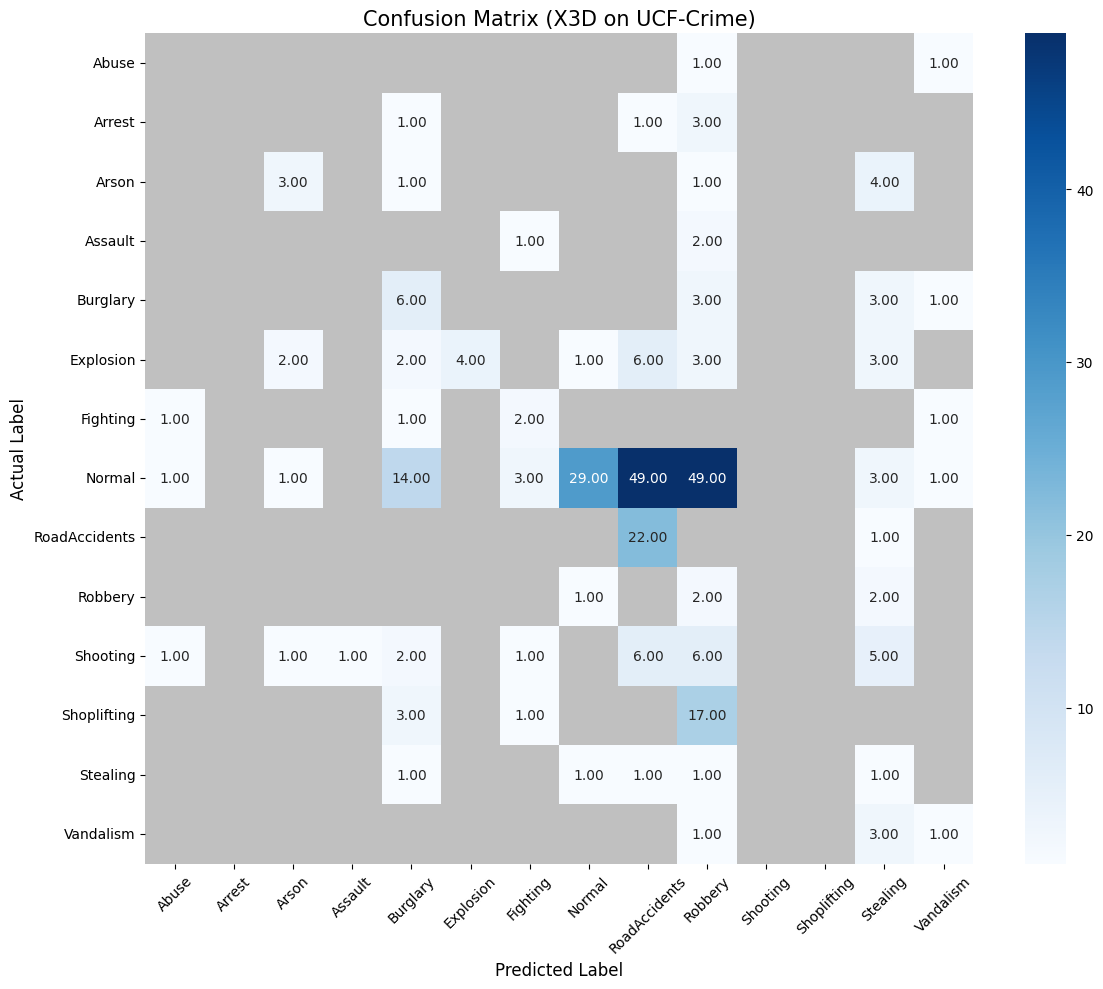

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(all_labels, all_preds, class_names):
    """
    all_labels: 실제 정답 리스트
    all_preds: 모델의 예측 리스트
    class_names: 클래스 이름 리스트 (인덱스 순서대로)
    """
    # Confusion Matrix 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 정규화 (행 단위로 합이 1이 되도록 - Recall 관점)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 시각화
    mask = (cm == 0.0) # 0.0 마스킹 (샘플 개수 희소해서)
    plt.figure(figsize=(12, 10))
    # sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                mask=mask)
    ax.set_facecolor("silver") # 마스킹 부분 컬러 고정

    plt.title("Confusion Matrix (X3D on UCF-Crime)", fontsize=15)
    plt.ylabel("Actual Label", fontsize=12)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # 결과 저장 및 출력
    plt.savefig("confusion_matrix_2_woNomalize.png")
    plt.show()

# 실행 예시
class_names = [
    "Abuse", "Arrest", "Arson", "Assault", "Burglary", 
    "Explosion", "Fighting", "Normal", "RoadAccidents", 
    "Robbery", "Shooting", "Shoplifting", "Stealing", "Vandalism"
]

# evaluate_model 함수에서 얻은 all_labels, all_preds를 입력
plot_confusion_matrix(all_labels, all_preds, class_names)

In [28]:
# save as png
plt.savefig('confusion_matrix_sgd_woNomalize.png')


<Figure size 640x480 with 0 Axes>

#### Get Predictions

In [29]:
print(inputs.size()) # c, t, h, W
print(inputs[None, ...].size()) # 1, C, T, H, W

NameError: name 'inputs' is not defined

In [ ]:
# Pass the input clip through the model
preds = model(inputs[None, ...])

# Get the predicted classes
# 로짓 값을 클래스명으로 매핑시키기 위한 후처리.
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names)) # 양궁, 도끼 던지기, 골프 높게 치는 샷, 골프 낮게 치는 샷, 보틀 열기

Top 5 predicted labels: archery, throwing axe, golf driving, golf chipping, opening bottle


In [ ]:
preds.size() # 400 = Kinetics 데이터셋의 클래스 개수

torch.Size([1, 400])

### Model Description
X3D model architectures are based on [1] pretrained on the Kinetics dataset.

| arch | depth | frame length x sample rate | top 1 | top 5 | Flops (G) | Params (M) |
| --------------- | ----------- | ----------- | ----------- | ----------- | ----------- |  ----------- | ----------- |
| X3D      | XS    | 4x12                       | 69.12 | 88.63 | 0.91      | 3.79     |
| X3D      | S     | 13x6                       | 73.33 | 91.27 | 2.96      | 3.79     |
| X3D      | M     | 16x5                       | 75.94 | 92.72 | 6.72      | 3.79     |


### References
[1] Christoph Feichtenhofer, "X3D: Expanding Architectures for
    Efficient Video Recognition." https://arxiv.org/abs/2004.04730

In [ ]:
!pip list |grep torch

torch                                    2.9.0+cpu
torchao                                  0.10.0
torchaudio                               2.9.0+cpu
torchdata                                0.11.0
torchsummary                             1.5.1
torchtune                                0.6.1
torchvision                              0.24.0+cpu


In [ ]:
!pip list |grep fvcore

fvcore                                   0.1.6


In [ ]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!python --version

Python 3.12.12


In [ ]:
!pip list |grep pytorchvideo

## Directly Inference on UCF-CRIME

In [ ]:
print(f"clip duration: {clip_duration} (sec)")

# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
ucf_video_path="/content/Abuse001_x264_7-12.mp4"
ucf_video = EncodedVideo.from_path(ucf_video_path) # pytorchvideo.data.encoded_video.EncodedVideo

# Load the desired clip
ucf_video_data = ucf_video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
ucf_video_transformed = transform(ucf_video_data)
ucf_inputs = ucf_video_transformed["video"] # 인코딩된 비디오 텐서값만
ucf_inputs = ucf_inputs.to(device)

ucf_preds = model(ucf_inputs[None, ...]) # 배치차원 추가하여 (1, C, T, H, W)

# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
ucf_pred_classes = post_act(ucf_preds)
ucf_pred_top5 = ucf_pred_classes.topk(k=5).indices[0]

# Map the predicted classes to the label names
ucf_pred_top5_names = [kinetics_id_to_classname[int(i)] for i in ucf_pred_top5]
print("Top 5 predicted labels: %s" % ", ".join(ucf_pred_top5_names))

clip duration: 2.6 (sec)
Top 5 predicted labels: moving furniture, cleaning floor, hoverboarding, using remote controller (not gaming), garbage collecting


In [ ]:
ucf_video_path="/content/Abuse001_x264_7-12.mp4"
ucf_video = EncodedVideo.from_path(ucf_video_path) # pytorchvideo.data.encoded_video.EncodedVideo

# Load the desired clip
ucf_video_data = ucf_video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
ucf_video_transformed = transform(ucf_video_data)
ucf_inputs = ucf_video_transformed["video"] # 인코딩된 비디오 텐서값만
ucf_inputs = ucf_inputs.to(device)

ucf_preds = model(ucf_inputs[None, ...]) # 배치차원 추가하여 (1, C, T, H, W)
ucf_pred_classes = post_act(ucf_preds)   # post_act = torch.nn.Softmax(dim=1)

# 확률값(v)과 인덱스(i) 모두 가져오기.
top5_probs, top5_indices = ucf_pred_classes.topk(k=5)

# 텐서 형태를 출력을 위한 넘파이로 변환
probs = top5_probs[0].detach().cpu().numpy()
indices = top5_indices[0].detach().cpu().numpy()

# 클래스 이름과 확률을 매핑해 출력.
print("Top 5 Predictions:")
for i in range(5):
    class_name = kinetics_id_to_classname[int(indices[i])]
    score = probs[i] * 100  # 퍼센트(%) 단위로 변환
    print(f"{i+1}: {class_name:<20} | Score: {score:.2f} (%)")

Top 5 Predictions:
1: moving furniture     | Score: 15.94 (%)
2: cleaning floor       | Score: 15.64 (%)
3: hoverboarding        | Score: 10.06 (%)
4: using remote controller (not gaming) | Score: 7.65 (%)
5: garbage collecting   | Score: 6.81 (%)
